In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [4]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Id          884262 non-null  int64  
 1   Dates       884262 non-null  object 
 2   DayOfWeek   884262 non-null  object 
 3   PdDistrict  884262 non-null  object 
 4   Address     884262 non-null  object 
 5   X           884262 non-null  float64
 6   Y           884262 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.2+ MB


In [6]:
train_df.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


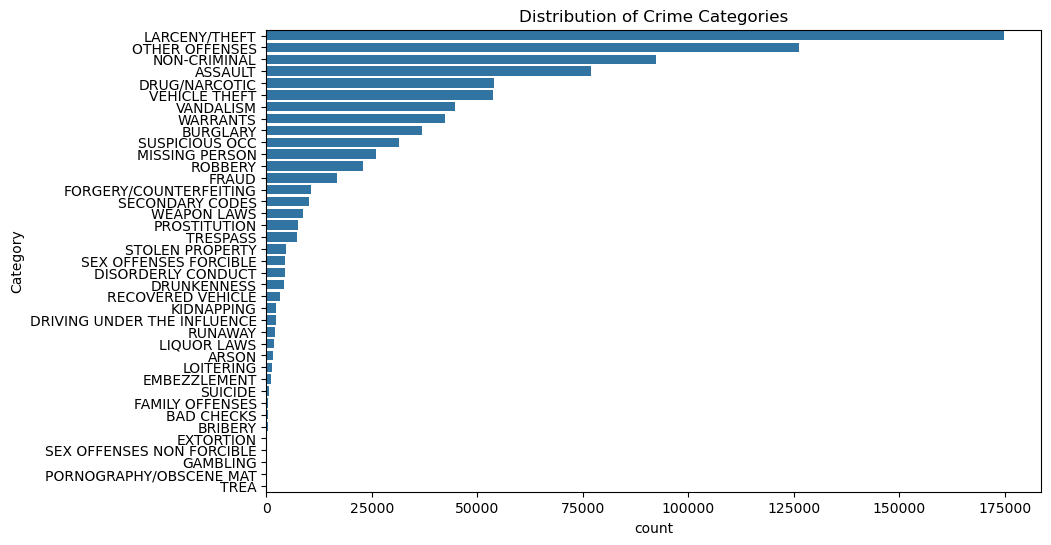

In [7]:
# Distribution of crime categories (use a bar plot)
plt.figure(figsize=(10,6))
sns.countplot(y='Category', data=train_df, order=train_df['Category'].value_counts().index)
plt.title('Distribution of Crime Categories')
plt.show()

In [10]:
def preprocess_data(df):
    # Converting 'Dates' from string to datetime object for the model
    df['Dates'] = pd.to_datetime(df['Dates'])

    # Extracting features like year, month, day, hour
    df['Year'] = df['Dates'].dt.year
    df['Month'] = df['Dates'].dt.month
    df['Day'] = df['Dates'].dt.day
    df['Hour'] = df['Dates'].dt.hour
    df['DayOfWeek'] = df['Dates'].dt.dayofweek

    # Dropping unnecessary columns
    columns_to_drop = ['Dates', 'Descript', 'Resolution', 'Id', 'Address']  # Add 'Address' if not needed
    df = df.drop(columns_to_drop, axis=1, errors='ignore')

    # Encoding categorical data (if needed)
    if 'PdDistrict' in df.columns:
        df['PdDistrict'] = LabelEncoder().fit_transform(df['PdDistrict'])
    
    return df




In [11]:
train_df = preprocess_data(train_df)


In [12]:
train_df.head()

,Category,DayOfWeek,PdDistrict,X,Y,Year,Month,Day,Hour
0,WARRANTS,2,4,-122.425892,37.774599,2015,5,13,23
1,OTHER OFFENSES,2,4,-122.425892,37.774599,2015,5,13,23
2,OTHER OFFENSES,2,4,-122.424363,37.800414,2015,5,13,23
3,LARCENY/THEFT,2,4,-122.426995,37.800873,2015,5,13,23
4,LARCENY/THEFT,2,5,-122.438738,37.771541,2015,5,13,23


In [13]:
test_df.head()

,DayOfWeek,PdDistrict,X,Y,Year,Month,Day,Hour
0,6,0,-122.399588,37.735051,2015,5,10,23
1,6,0,-122.391523,37.732432,2015,5,10,23
2,6,4,-122.426002,37.792212,2015,5,10,23
3,6,2,-122.437394,37.721412,2015,5,10,23
4,6,2,-122.437394,37.721412,2015,5,10,23


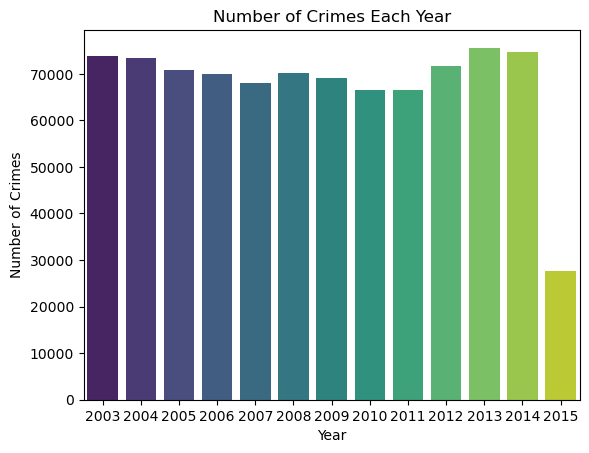

In [14]:
# Plotting the number of crimes each hour of the day
sns.countplot(x='Year', data=train_df, palette='viridis')
plt.title('Number of Crimes Each Year')
plt.ylabel('Number of Crimes')
plt.xlabel('Year')
plt.show()

In [15]:
#encoding category column
label_enc_category = LabelEncoder()
train_df['Category'] = label_enc_category.fit_transform(train_df['Category'])

In [16]:
# Splitting data into features and target in training data
X_train = train_df.drop('Category', axis=1)
y_train = train_df['Category']

# Encoding target variable
y_train = LabelEncoder().fit_transform(y_train)

In [17]:
#fitting model
model = xgb.XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y_train)))
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=39,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [29]:
# Getting the most likely category for each prediction
y_pred_max = np.argmax(y_pred, axis=1)
y_pred_categories = label_enc_category.inverse_transform(y_pred_max)




In [30]:
# Creating a DataFrame for the most likely categories
y_pred_cat_df = pd.DataFrame(y_pred_categories, columns=['Predicted_Category'])

In [31]:
y_pred_cat_df

,Predicted_Category
0,VEHICLE THEFT
1,OTHER OFFENSES
2,LARCENY/THEFT
3,VEHICLE THEFT
4,VEHICLE THEFT
...,...
884257,SEX OFFENSES FORCIBLE
884258,FORGERY/COUNTERFEITING
884259,ASSAULT
884260,OTHER OFFENSES


In [34]:
# Since I removed Id column earlier I am Reading the column separately as running the model again would take considerable time again
test_ids = pd.read_csv('test.csv', usecols=['Id'])



In [35]:
# Performing predictions
test_df = preprocess_data(pd.read_csv('test.csv'))
y_pred = model.predict_proba(test_df)



In [36]:
# Combining the 'Id' column with the results
y_pred_cat_df = pd.DataFrame(y_pred_categories, columns=['Predicted_Category'])
pred_output = pd.concat([test_ids, y_pred_cat_df], axis=1)

In [37]:
pred_output

,Id,Predicted_Category
0,0,VEHICLE THEFT
1,1,OTHER OFFENSES
2,2,LARCENY/THEFT
3,3,VEHICLE THEFT
4,4,VEHICLE THEFT
...,...,...
884257,884257,SEX OFFENSES FORCIBLE
884258,884258,FORGERY/COUNTERFEITING
884259,884259,ASSAULT
884260,884260,OTHER OFFENSES


In [38]:
# exporting to submission.csv
pred_output.to_csv('submission.csv', index=False)